The following notebook will contain a brief explanation of what isomap and MDS are, and examples of how isomap behaves with high-dimensional data. In particular the examples which will be shown are the **S-curve**, **handwritten digits**, and **severed sphere**.

### Isometric feature mapping (isomap)

Isomap is an extension of Multidimensional Scaling(MDS). Isomap builds a neighborhood graph connecting the points on the manifold to each other if they are a K nearest neighbor(kNN). The length of each edge connecting the points corresponds to the Euclidean distance, which coincides with the geodesic distance on the manifold.


Next thing is to compute the shortest path between two nodes from the new formed graph [Here Djikstra's algorithm can be used]. The result of this step is a matrix D which contains the shortest path distances between all pairs of points. Then the matrix D is passed as parameter to MDS so as embed the input data into a lower dimension.

In MDS we create a new matrix by double centering the dissimilarity matrix; and then solve the equation $B_\Delta=Q\Lambda Q^\top$ as a generalized eigenproblem. We choose $K$ eigenvectors with the highest $K$ eigenvalues More on that on the wiki about MDS/isomap.





### S-curve

We begin by importing the necessary libraries and plotting what we mean by a s-curve

In [12]:
from numpy.random import RandomState
import matplotlib.pyplot as plt
from matplotlib import ticker
import mpl_toolkits.mplot3d
from sklearn import manifold, datasets


We then make the s-curve based on the number of samples that we choose

In [13]:
rng = RandomState(0)
n_samples = 1500
S_points, S_color = datasets.make_s_curve(n_samples, random_state=rng)


Here are some functions that plot the data for us

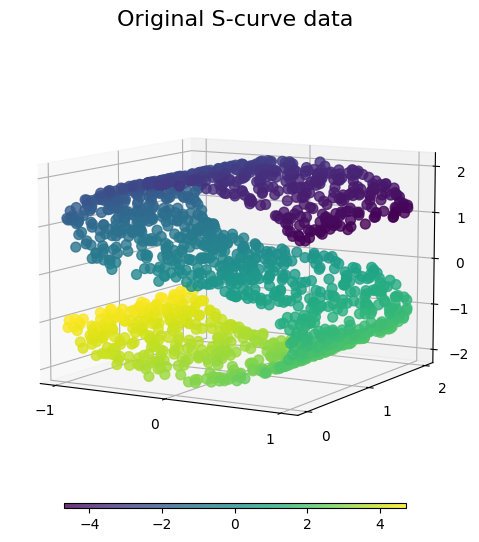

In [14]:
def plot_3d(points, points_color, title):
    x,y,z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)

    col= ax.scatter(x,y,z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()

def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())


plot_3d(S_points, S_color, "Original S-curve data")
#apparently doesn't work in 3d as expected

We choose the number of neighbors $K$ that we want to include. Choosing a high $K$ might not be a good idea. The number of components is the number of coordinates for the manifold.
The class isomap gets initialized with the said parameters + $p=1$ which is equivalent to Manhattan distance

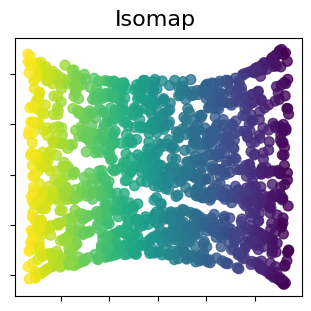

In [15]:
n_neighbors = 12
n_components = 2

isomap = manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
S_isomap = isomap.fit_transform(S_points)

plot_2d(S_isomap, S_color, "Isomap")


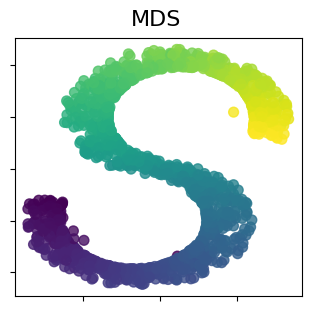

In [16]:
#Here is an example of MDS, and as we will see, it will perform worse than isomap
mds = manifold.MDS(n_components=n_components, max_iter=50, n_init=4, random_state=rng)
S_mds = mds.fit_transform(S_points)
plot_2d(S_mds, S_color, "MDS")

### Severed sphere

In [17]:
#License : BSD 3 clause

from time import time
import numpy as np
from matplotlib.pyplot import NullFormatter
from sklearn.utils import check_random_state
import warnings


ISO: 1.3 sec
MDS: 8.6 sec


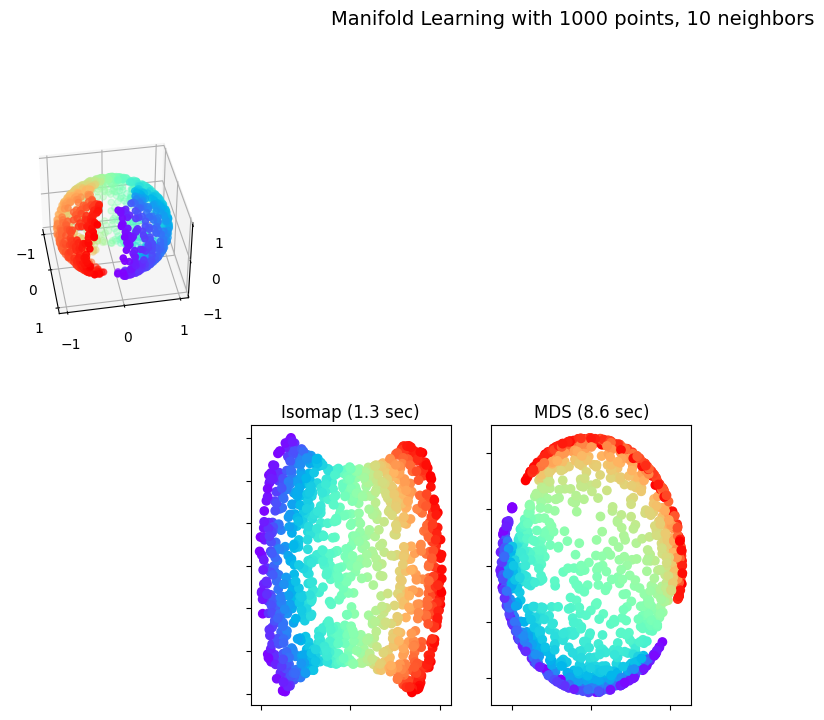

In [18]:
#now we can change the neigbors and samples size
n_neighbors = 10
n_components = 1000

#create the sphere
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

#sever the poles from the sphere
indices = (t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8)))
colors = p[indices]

x, y, z =(
    np.sin(t[indices]) * np.cos(p[indices]),
    np.sin(t[indices]) * np.sin(p[indices]),
    np.cos(t[indices]),
)

#dataset
fig = plt.figure(figsize=(15,8))
plt.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (1000, n_neighbors), fontsize=14
)

ax = fig.add_subplot(251, projection="3d")
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T


#isomap
t0 = time()
transformed_data = (
    manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(sphere_data).T
)
t1=time()
print("%s: %.2g sec" % ("ISO", t1-t0))

#plotting details
ax = fig.add_subplot(257)
plt.scatter(transformed_data[0], transformed_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ("Isomap", t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

#mds
t0 = time()
mds = manifold.MDS(n_components=2, max_iter=100, n_init=1)
transformed_data = mds.fit_transform(sphere_data).T
t1=time()
print("%s: %.2g sec" % ("MDS", t1-t0))

#plotting details
ax = fig.add_subplot(258)
plt.scatter(transformed_data[0], transformed_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")


plt.show()


### Handwritten digits

In [19]:
from sklearn.datasets import load_digits

digits = load_digits(n_class=10)

X, y = digits.data, digits.target
n_samples , n_features = X.shape
n_neighbors =30


In case anyone is interested in seeing the data, one can run the following code snippet

In [20]:
fig, axs = plt.subplots(nrows=10,ncols=10,figsize=(6,6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)


KeyboardInterrupt: 

<Figure size 600x600 with 0 Axes>

In [ ]:
#imports
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import (Isomap, MDS)

#plot
def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every digit on the embedding
        # show an annotation box for a group of digits
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")


As for now I don't understand the SMACOF algorithm which MDS uses. **n_jobs** refers to the number jobs to compute the algorithm. **n_init** refers to number of times that SMACOF is computed with different initializations. **max_iter** refers to the amount of iterations SMACOF runs for a single computation. 

Computing Isomap method
Computing MDS method


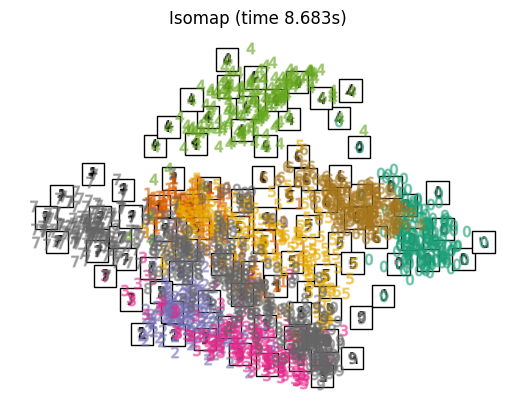

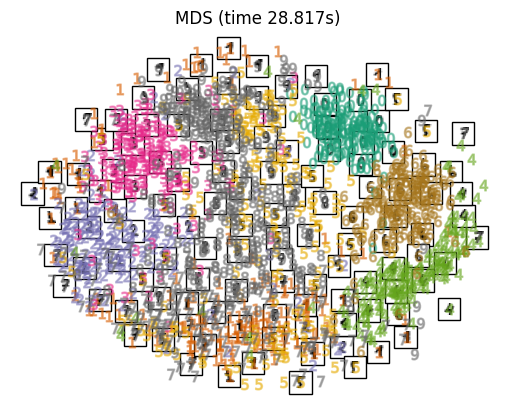

In [ ]:
embeddings = {
    "Isomap": Isomap(n_neighbors=n_neighbors, n_components=2),
    "MDS": MDS(n_components=2, n_init=1, max_iter=120, n_jobs=2),
}

projections , timing = {}, {}
for name, transformer in embeddings.items():
    data = X

    print(f"Computing {name} method")
    t0=time()
    projections[name]=transformer.fit_transform(data, y)
    timing[name] = time() - t0


for name in timing:
    title = f"{name} (time {timing[name]:.3f}s)"
    plot_embedding(projections[name], title)


plt.show()